In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import csv
import unidecode 
import pandas.core.algorithms as algos
from scipy.stats import kendalltau   
from funcoes_uteis import *
from dateutil.relativedelta import relativedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_base = pd.read_csv('./Churn_Consumo_Recomendacao_17.07.2017.csv'
                      , error_bad_lines = False
                      , sep=';'
                      , dtype= {7: str}
                      , encoding='latin-1'
                      , header = None)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_base.sample(10).T

,6008346,7351137,650399,7081843,2883643,389973,6253519,1730932,7110039,7122167
0,62528180,64115535,917549,63809431,6123490,558655,62839765,3063909,63841606,63855490
1,__84194120906__,__09987935745__,__13197510000142__,__94730970187__,__05508625000182__,__01796785000113__,__00700447245__,__09227188000180__,__15080474000168__,__10437564770__
2,"99,90","0,00","0,00","54,90","0,00","29,00","0,00","1730,00","49,90","0,00"
3,Mensal,Mensal,Trimestral,Anual,NaN,Trimestral,Mensal,Trimestral,Anual,Trimestral
4,2015-04-22 00:00:00.000,2016-10-06 00:00:00.000,2007-04-11 00:00:00.000,2016-06-23 00:00:00.000,2011-09-26 00:00:00.000,2006-03-21 00:00:00.000,2015-08-05 00:00:00.000,2009-09-29 00:00:00.000,2016-07-05 00:00:00.000,2016-07-07 00:00:00.000
5,2013-04-25,2014-10-20,1998-07-02,2015-08-12,2003-02-20,2006-03-21,2015-08-05,2009-09-27,2012-08-03,2016-06-03
6,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000
7,SIM,nao,nao,SIM,nao,SIM,nao,SIM,SIM,nao
8,1,1,1,1,38,1,1,1,1,1
9,Revenda Hosp.,Hospedagem,Email,Registro Dominio,Hospedagem,Hospedagem,Cloud Server Pro,Servidor Dedicado,Hospedagem,Hospedagem


In [4]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

def periodicidade(x):
    if x == 'Trienal':
        return 36    
    elif x == 'Anual':
        return 12
    elif x == 'Semestral':
        return 6
    elif x == 'Trimestral':
        return 3
    else: 
        return 1

def marca_lista(lista, tamanho, variavel):
    i = 0
    for i in range(tamanho):
        if variavel == lista[i]: return i
                
def cria_curva(percentiles, variavel):
    Perc = list()
    for i in range(len(percentiles)):
        Perc.append(np.percentile(variavel, percentiles[i]))
    return Perc

def marca_base(Perc, x):
    if x >= Perc[(len(Perc)-1)]:
        return len(Perc) +1
    else:
        for i in range(len(Perc)):
            if x < Perc[i]:
                return i + 1

In [5]:
s = ['Provisioning', 'cd_ChaveCliente', 'nr_PrecoMensal', 'ds_Periodicidade', 'Instalacao', 
     'Primeiro_Servico_LW', 'dt_Reativacao', 'fl_ServicoPai', 'id_GerenteConta', 'Servico', 
     'fl_Dev', 'Perfil', 'classificacao', 'Status', 'Data_Fim', 'Data_Desativacao']

df_base.columns = s

In [6]:
df_base['Status'] = ['ativo' if s in ['Ativo', 'Atendido', 'Em ativação',
                                      'Aguardando ativação'] else 'inativo'
                     for s in df_base.Status]

df_base = df_base[(df_base.nr_PrecoMensal != '0,00')].copy()
df_base.sort_values(['Instalacao'], ascending= 1 ,inplace=True)
df_base.drop_duplicates(['Provisioning'], keep='last', inplace= True)
col_datas = ['Data_Desativacao', 'Data_Fim', 'Instalacao', 'dt_Reativacao', 'Primeiro_Servico_LW']
converte_datetime(df_base, col_datas)
df_base['Data_Fim_flag'] = [1 if d_fim != datetime(1900,1,1) else 0 for d_fim in df_base.Data_Fim]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_churn'] = df_base[['Data_Fim', 'Data_Desativacao']].min(axis = 1).astype('datetime64[ns]')
df_base['Data_churn'] = [d_fim if ((d_des < d_rea < d_fim) & f_fim & f_des) else d_chu
                              for d_des, d_rea, d_fim, f_fim, f_des, d_chu in 
                              zip(df_base.Data_Desativacao, df_base.dt_Reativacao, 
                                  df_base.Data_Fim, df_base.Data_Fim_flag, 
                                  df_base.Data_Desativacao_flag, df_base.Data_churn)]
df_base['Data_churn_flag'] = [1 if d > datetime(1900, 1, 1) else 0 for d in df_base.Data_churn]
df_base['Primeiro_Servico_LW_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Primeiro_Servico_LW]
df_base['Instalacao_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Instalacao]
df_base['Data_churn_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Data_churn]
df_base['fl_ServicoPai'] = [1 if s in ['SIM', 'Sim', 'sim'] else 0 for s in df_base.fl_ServicoPai]
df_base['fl_GerenteConta'] = [0 if s== 1 else 1 for s in df_base.id_GerenteConta]
df_base['nr_PrecoMensal'] = [x.replace(',', '.') for x in df_base.nr_PrecoMensal]
df_base['nr_PrecoMensal'] = df_base.nr_PrecoMensal.astype(float)
df_base['MesesParaChurn'] = [diff_month(ch, ins) if ch > datetime(1900, 1, 1) else 0
                           for ch, ins in  zip(df_base.Data_churn, df_base.Instalacao)]
df_base['FlagChurn'] = [1 if d!= 0 else 0 for d in df_base.MesesParaChurn]

In [7]:
from dateutil.relativedelta import relativedelta
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-3)
inicio_janela_churn = fim_janela_feature
fim_janela_churn = fim_janela_feature+ relativedelta(months=2)

In [8]:
df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                    (df_base.MesesParaChurn == 0) &
                    (df_base.Status == 'ativo')].copy()
df_treino_fut = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                    (df_base.Data_churn > fim_janela_churn)].copy()
df_treino_fut['FlagChurn'] = 0
df_treino_churn = df_base[(df_base.Data_churn >= inicio_janela_churn) & 
                          (df_base.Data_churn < fim_janela_churn)].copy()
df_treino = pd.concat([df_treino, df_treino_churn, df_treino_fut])

In [9]:
agg_dict = {'Provisioning' : 'count'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'Provisioning': 'Qtd_Provisioning'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

agg_dict = {'nr_PrecoMensal' : 'sum'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'nr_PrecoMensal': 'Valor_cliente_Mes'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

In [10]:
df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
df_treino['quantidade_renovacoes'] = [int(id_prov/peri_mes) for 
                                      id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                       peri_mes,idade_prov,qtd_renov in 
                                       zip(df_treino.Periodicidade_Meses, 
                                           df_treino.idade_prov, 
                                           df_treino.quantidade_renovacoes)]
df_treino['mes_Proxima_renovacao'] = [datetime((d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).year,
                                               (d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).month,1) 
                                      for d, qtd_renovacoes, periodicidade, mdelta in 
                                      zip (df_treino.Instalacao_AnoMes, 
                                           df_treino.quantidade_renovacoes,
                                           df_treino.Periodicidade_Meses,
                                           df_treino.Qtd_meses_P_renovacoes)]

In [11]:
lista_perfil = df_treino.Perfil.unique()
tamanho = len(lista_perfil) 
df_treino['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                               for variavel in df_treino.Perfil]
lista_classificacao = df_treino.classificacao.unique()
tamanho = len(lista_classificacao) 
df_treino['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                     for variavel in df_treino.classificacao]
lista_servico = df_treino.Servico.unique()
tamanho = len(lista_servico) 
df_treino['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                               for variavel in df_treino.Servico]

In [12]:
df_treino.columns

Index(['Provisioning', 'cd_ChaveCliente', 'nr_PrecoMensal', 'ds_Periodicidade',
       'Instalacao', 'Primeiro_Servico_LW', 'dt_Reativacao', 'fl_ServicoPai',
       'id_GerenteConta', 'Servico', 'fl_Dev', 'Perfil', 'classificacao',
       'Status', 'Data_Fim', 'Data_Desativacao', 'Data_Fim_flag',
       'Data_Desativacao_flag', 'Data_churn', 'Data_churn_flag',
       'Primeiro_Servico_LW_AnoMes', 'Instalacao_AnoMes', 'Data_churn_AnoMes',
       'fl_GerenteConta', 'MesesParaChurn', 'FlagChurn', 'Qtd_Provisioning',
       'Valor_cliente_Mes', 'Periodicidade_Meses', 'idade_prov', 'idade_cli',
       'quantidade_renovacoes', 'Qtd_meses_P_renovacoes',
       'mes_Proxima_renovacao', 'Perfil_indice', 'classificacao_indice',
       'Servico_indice'],
      dtype='object')

# Exceto Registro de Dominio

In [13]:
colunas= ['nr_PrecoMensal', 'fl_ServicoPai',
          'fl_Dev', 'fl_GerenteConta', 'Qtd_Provisioning',
          'Valor_cliente_Mes', 'Periodicidade_Meses', 'idade_prov', 
          'idade_cli', 'quantidade_renovacoes', 'Qtd_meses_P_renovacoes',
          'Perfil_indice', 'classificacao_indice', 'Servico_indice', 'FlagChurn']
df_treino.fillna(0, inplace= True)
Explicativas = df_treino[df_treino.Servico != 'Registro Dominio'][colunas].copy()

In [14]:
# shuffle rows
X = Explicativas.sample(frac = 1)
# create X and y matrices
y = X.FlagChurn.values
Colunas_Modelo = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).columns
X = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).values
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
auc_list = []
k = 1
for train, valid in skf.split(X, y):
    print('Fold #', k)
    print("train indices: %s\nvalidation indices %s" % (train, valid))
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10)
    clf.fit(X[train], y[train])
    y_pred = clf.predict_proba(X[valid])
    auc = roc_auc_score(y[valid], y_pred[:,1])
    auc_list.append(auc)
    print('AUC on fold #', k, ':', auc, '\n')
    k += 1
    
print('Average AUC on', k-1, 'folds:', np.mean(auc_list))

Fold # 1
train indices: [148009 148010 148011 ..., 296019 296020 296021]
validation indices [     0      1      2 ..., 148072 148107 148112]
AUC on fold # 1 : 0.796000380327 

Fold # 2
train indices: [     0      1      2 ..., 148072 148107 148112]
validation indices [148009 148010 148011 ..., 296019 296020 296021]
AUC on fold # 2 : 0.798187246366 

Average AUC on 2 folds: 0.797093813347


# Registro de Dominio

In [15]:
colunas= ['nr_PrecoMensal', 'fl_ServicoPai',
          'fl_Dev', 'fl_GerenteConta', 'Qtd_Provisioning',
          'Valor_cliente_Mes', 'Periodicidade_Meses', 'idade_prov', 
          'idade_cli', 'quantidade_renovacoes', 'Qtd_meses_P_renovacoes',
          'Perfil_indice', 'classificacao_indice', 'Servico_indice', 'FlagChurn']
df_treino.fillna(0, inplace= True)
Explicativas = df_treino[df_treino.Servico == 'Registro Dominio'][colunas].copy()

In [16]:
# shuffle rows
X = Explicativas.sample(frac = 1)
# create X and y matrices
y = X.FlagChurn.values
Colunas_Modelo = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).columns
X = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).values
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
auc_list = []
k = 1
for train, valid in skf.split(X, y):
    print('Fold #', k)
    print("train indices: %s\nvalidation indices %s" % (train, valid))
    clf_RegDom = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10)
    clf_RegDom.fit(X[train], y[train])
    y_pred = clf_RegDom.predict_proba(X[valid])
    auc = roc_auc_score(y[valid], y_pred[:,1])
    auc_list.append(auc)
    print('AUC on fold #', k, ':', auc, '\n')
    k += 1
    
print('Average AUC on', k-1, 'folds:', np.mean(auc_list))

Fold # 1
train indices: [106384 106447 106454 ..., 214158 214159 214160]
validation indices [     0      1      2 ..., 107152 107153 107154]
AUC on fold # 1 : 0.859774723995 

Fold # 2
train indices: [     0      1      2 ..., 107152 107153 107154]
validation indices [106384 106447 106454 ..., 214158 214159 214160]
AUC on fold # 2 : 0.861547491085 

Average AUC on 2 folds: 0.86066110754


#


#


# Cria Cluster-  Exceto Registro de Dominio

In [17]:
#cria copia da original- Auxiliar()
df_original = df_treino.copy()

#

In [18]:
df_treino = df_original[df_original.Servico != 'Registro Dominio'].copy()
df_treino.reset_index(drop= True, inplace= True)

X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)

y_pred = clf.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)

In [19]:
df_treino = pd.concat([df_treino, y_pred], axis = 1)

In [20]:
percentiles = list()
inicio = 0
fim = 100
salto = 0.25
aux = round((fim - inicio)/salto)
for i in range(aux):
    percentiles.append((inicio +i*salto))

Perc = cria_curva(percentiles, df_treino.Prob_Churn)
df_treino['Prob_Churn_Grupo'] = [marca_base(Perc, x) for x in df_treino.Prob_Churn]
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean'}
RESUMO = df_treino.groupby('Prob_Churn_Grupo').agg(dict_lista_aux)
RESUMO.sort_values(['Prob_Churn'], ascending= 0 ,inplace=True)
RESUMO.Prob_Churn = round(RESUMO.Prob_Churn, ndigits = 2)
RESUMO['FlagChurn_aux'] = [p*q for p, q in zip (RESUMO.FlagChurn, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.FlagChurn_aux.cumsum()
RESUMO['FlagChurn_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
RESUMO['Prob_Chrun_aux'] = [p*q for p, q in zip (RESUMO.Prob_Churn, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.Prob_Chrun_aux.cumsum()
RESUMO['Prob_Chrun_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
RESUMO.reset_index(inplace= True)

lista = RESUMO.FlagChurn_acumulado
Prob_aux1 = RESUMO.loc[0].FlagChurn_acumulado
curva_indice = []
for i in range(len(lista)):
    Prob_aux2 = lista[i]
    if len(curva_indice) < 9 and Prob_aux1/Prob_aux2 >= 1.25:
        Prob_aux1 = Prob_aux2 
        curva_indice.append(i)

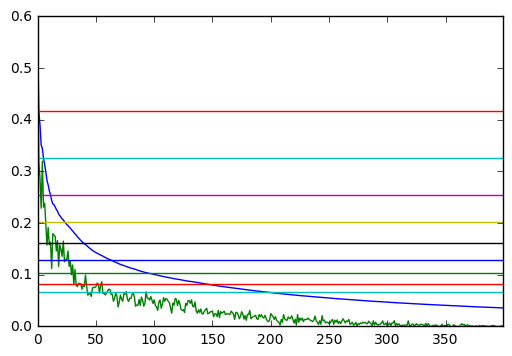

In [21]:
RESUMO['r1']= RESUMO.FlagChurn_acumulado.loc[curva_indice[0]]
RESUMO['r2']= RESUMO.FlagChurn_acumulado.loc[curva_indice[1]]
RESUMO['r3']= RESUMO.FlagChurn_acumulado.loc[curva_indice[2]]
RESUMO['r4']= RESUMO.FlagChurn_acumulado.loc[curva_indice[3]]
RESUMO['r5']= RESUMO.FlagChurn_acumulado.loc[curva_indice[4]]
RESUMO['r6']= RESUMO.FlagChurn_acumulado.loc[curva_indice[5]]
RESUMO['r7']= RESUMO.FlagChurn_acumulado.loc[curva_indice[6]]
RESUMO['r8']= RESUMO.FlagChurn_acumulado.loc[curva_indice[7]]
RESUMO['r9']= RESUMO.FlagChurn_acumulado.loc[curva_indice[8]]


%matplotlib inline
import matplotlib.pyplot as plt

RESUMO.FlagChurn_acumulado.plot()
RESUMO.FlagChurn.plot()
RESUMO.r1.plot()
RESUMO.r2.plot()
RESUMO.r3.plot()
RESUMO.r4.plot()
RESUMO.r5.plot()
RESUMO.r6.plot()
RESUMO.r7.plot()
RESUMO.r8.plot()
RESUMO.r9.plot()

In [22]:
Perc = []
for i in range(len(curva_indice)):
    Perc.append(RESUMO.FlagChurn_acumulado.loc[curva_indice[i]])
Perc = Perc[::-1]

RESUMO['Cluster'] = [marca_base(Perc, x) for x in RESUMO.FlagChurn_acumulado]
RESUMO.reset_index(inplace= True, drop= True)

In [23]:
lista = [RESUMO[RESUMO.Cluster == 1].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 2].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 3].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 4].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 5].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 6].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 7].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 8].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 9].Prob_Churn_Grupo.max()]

In [24]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.Prob_Churn_Grupo]
aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
aux_Cluster.sort_index(inplace= True)
aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()

dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'Valor_cliente_Mes' : 'mean',
                  'Periodicidade_Meses' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean'}
RESUMO = df_treino.groupby('Cluster').agg(dict_lista_aux)

In [25]:
import seaborn as sns
agg_dict_heatmap = {'Provisioning' : 'count'}
heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
heatmap.reset_index(inplace= True)
heatmap = heatmap.pivot('Cluster','Servico', 'Provisioning').copy()
heatmap.fillna(0, inplace= True)
heatmap = heatmap.T
heatmap['total'] = heatmap[heatmap.columns].sum(axis = 1)
heatmap.sort('total', ascending= 0, inplace= True)
heatmap.drop('total', axis= 1)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Hospedagem,104793.0,26751.0,19659.0,15453.0,13464.0,9548.0,5761.0,3626.0,2236.0,1236.0
Email,16113.0,1621.0,1109.0,203.0,40.0,36.0,42.0,14.0,0.0,3.0
Email MKT,523.0,1333.0,2286.0,2285.0,1519.0,1255.0,1307.0,191.0,295.0,124.0
Criador de Sites,10582.0,28.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
Exchange,5173.0,3272.0,1311.0,215.0,48.0,23.0,60.0,4.0,5.0,6.0
Cloud Server Pro,1652.0,1326.0,3504.0,1629.0,440.0,364.0,472.0,119.0,81.0,107.0
Revenda Hosp.,1267.0,2163.0,2401.0,1361.0,249.0,130.0,284.0,120.0,75.0,71.0
WR,1741.0,1413.0,963.0,629.0,202.0,50.0,54.0,16.0,4.0,0.0
PABX Virtual,836.0,1168.0,1263.0,395.0,174.0,76.0,249.0,91.0,78.0,210.0


In [26]:
import seaborn as sns
agg_dict_heatmap = {'FlagChurn' : 'mean'}
heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
heatmap.reset_index(inplace= True)
heatmap = heatmap.pivot('Cluster','Servico', 'FlagChurn').copy()
heatmap.fillna(0, inplace= True)
heatmap = heatmap.T
heatmap['total'] = heatmap[heatmap.columns].sum(axis = 1)
heatmap.sort('total', ascending= 0, inplace= True)
heatmap.drop('total', axis= 1)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Servidor Dedicado,0.001506,0.007092,0.052731,0.072848,0.277778,0.700000,0.484848,0.666667,1.000000,1.000000
SSL,0.005020,0.037975,0.035714,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
Revenda EMKT,0.000000,0.111111,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
Exchange,0.006959,0.018337,0.081617,0.134884,0.291667,0.130435,0.283333,0.500000,0.400000,0.833333
Licencas - Dedicado,0.002924,0.021277,0.029493,0.084034,0.088710,0.232877,0.451613,0.250000,0.545455,0.686275
Cloud Server Pro,0.008475,0.019608,0.046518,0.081031,0.109091,0.145604,0.269068,0.394958,0.308642,0.635514
Gateway Pagtos,0.000000,0.025641,0.032895,0.046647,0.083077,0.555556,0.000000,0.000000,0.000000,1.000000
WR,0.006893,0.012739,0.037383,0.052464,0.128713,0.100000,0.111111,0.500000,0.750000,0.000000
Cloud VPS,0.041667,0.000000,0.011494,0.044776,0.071429,0.113208,0.179348,0.265487,0.361111,0.530151


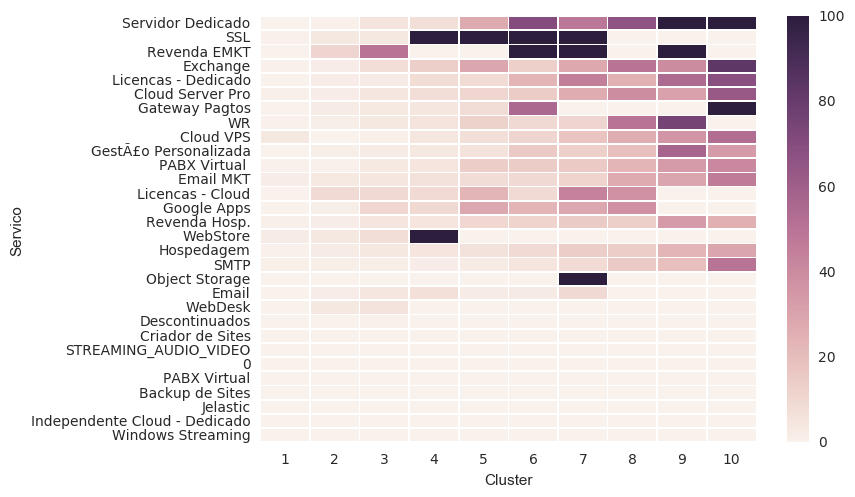

In [27]:
for i in heatmap.columns:
    heatmap[i] = heatmap[i]*100
sns.heatmap(heatmap.drop('total', axis = 1), annot=False, linewidths=.5)    

In [28]:
#NomeCSV = 'Prob_Churn_ResumoTreino.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [29]:
#RESUMO

# Aplicando na Base-  Exceto Registro de Dominio

In [30]:
fim_janela_feature = df_base.Instalacao.max()
inicio_janela_churn = fim_janela_feature

df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                    (df_base.MesesParaChurn == 0) &
                    (df_base.Status == 'ativo') &
                    (df_base.Servico != 'Registro Dominio')].copy()

In [31]:
agg_dict = {'Provisioning' : 'count'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'Provisioning': 'Qtd_Provisioning'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

agg_dict = {'nr_PrecoMensal' : 'sum'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'nr_PrecoMensal': 'Valor_cliente_Mes'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

In [32]:
df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
df_treino['quantidade_renovacoes'] = [int(id_prov/peri_mes) for 
                                      id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                       peri_mes,idade_prov,qtd_renov in 
                                       zip(df_treino.Periodicidade_Meses, 
                                           df_treino.idade_prov, 
                                           df_treino.quantidade_renovacoes)]
df_treino['mes_Proxima_renovacao'] = [datetime((d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).year,
                                               (d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).month,1) 
                                      for d, qtd_renovacoes, periodicidade, mdelta in 
                                      zip (df_treino.Instalacao_AnoMes, 
                                           df_treino.quantidade_renovacoes,
                                           df_treino.Periodicidade_Meses,
                                           df_treino.Qtd_meses_P_renovacoes)]

In [33]:
tamanho = len(lista_perfil) 
df_treino['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                               for variavel in df_treino.Perfil]
tamanho = len(lista_classificacao) 
df_treino['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                     for variavel in df_treino.classificacao]
tamanho = len(lista_servico) 
df_treino['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                               for variavel in df_treino.Servico]

In [34]:
df_treino.fillna(0, inplace= True)

In [35]:
X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)
y_pred = clf.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)
y_pred.shape
df_treino = pd.concat([df_treino, y_pred], axis=1)

In [36]:
df_treino.sort_values(['Prob_Churn'], ascending= 1 ,inplace=True)

In [37]:
df_treino.reset_index(inplace= True, drop= True)
df_treino.reset_index(inplace= True)

In [38]:
df_treino.rename(columns= {'index': 'aux_cluster'}, inplace= True)

In [39]:
lista = [round(aux_Cluster[aux_Cluster.index == 1].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 2].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 3].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 4].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 5].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 6].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 7].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 8].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 9].Perc.max()*df_treino.aux_cluster.max(),0)]

In [40]:
lista[1] = lista[1] + lista[0]
lista[2] = lista[2] + lista[1]
lista[3] = lista[3] + lista[2]
lista[4] = lista[4] + lista[3]
lista[5] = lista[5] + lista[4]
lista[6] = lista[6] + lista[5]
lista[7] = lista[7] + lista[6]
lista[8] = lista[8] + lista[7]

In [41]:
#lista

In [42]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.aux_cluster]

In [43]:
#df_treino.Cluster.value_counts()

In [44]:
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'Valor_cliente_Mes' : 'mean',
                  'Periodicidade_Meses' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean'}
RESUMO = df_treino.groupby('Cluster').agg(dict_lista_aux)
#NomeCSV = 'Prob_Churn_ResumoBaseAtiva.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [45]:
#NomeCSV = 'Prob_Churn.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#df_treino[['Cluster','Provisioning']].set_index(['Cluster']).to_csv(NomeCSV)

In [46]:
#NomeCSV
#RESUMO

In [47]:
df_ExcetoRegDominio = df_treino.copy()

#


#


# Cria Cluster-  Registro de Dominio

#

In [48]:
df_treino = df_original[df_original.Servico == 'Registro Dominio'].copy()
df_treino.reset_index(drop= True, inplace= True)

X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)

y_pred = clf_RegDom.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)

In [49]:
df_treino = pd.concat([df_treino, y_pred], axis = 1)

In [50]:
percentiles = list()
inicio = 0
fim = 100
salto = 0.25
aux = round((fim - inicio)/salto)
for i in range(aux):
    percentiles.append((inicio +i*salto))

Perc = cria_curva(percentiles, df_treino.Prob_Churn)
df_treino['Prob_Churn_Grupo'] = [marca_base(Perc, x) for x in df_treino.Prob_Churn]
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean'}
RESUMO = df_treino.groupby('Prob_Churn_Grupo').agg(dict_lista_aux)
RESUMO.sort_values(['Prob_Churn'], ascending= 0 ,inplace=True)
RESUMO.Prob_Churn = round(RESUMO.Prob_Churn, ndigits = 2)
RESUMO['FlagChurn_aux'] = [p*q for p, q in zip (RESUMO.FlagChurn, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.FlagChurn_aux.cumsum()
RESUMO['FlagChurn_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
RESUMO['Prob_Chrun_aux'] = [p*q for p, q in zip (RESUMO.Prob_Churn, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.Prob_Chrun_aux.cumsum()
RESUMO['Prob_Chrun_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
RESUMO.reset_index(inplace= True)

lista = RESUMO.FlagChurn_acumulado
Prob_aux1 = RESUMO.loc[0].FlagChurn_acumulado
curva_indice = []
for i in range(len(lista)):
    Prob_aux2 = lista[i]
    if len(curva_indice) < 9 and Prob_aux1/Prob_aux2 >= 1.25:
        Prob_aux1 = Prob_aux2 
        curva_indice.append(i)

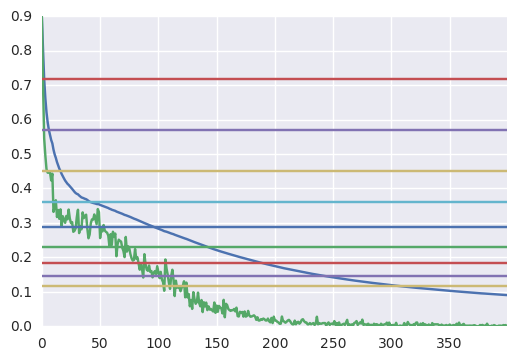

In [51]:
RESUMO['r1']= RESUMO.FlagChurn_acumulado.loc[curva_indice[0]]
RESUMO['r2']= RESUMO.FlagChurn_acumulado.loc[curva_indice[1]]
RESUMO['r3']= RESUMO.FlagChurn_acumulado.loc[curva_indice[2]]
RESUMO['r4']= RESUMO.FlagChurn_acumulado.loc[curva_indice[3]]
RESUMO['r5']= RESUMO.FlagChurn_acumulado.loc[curva_indice[4]]
RESUMO['r6']= RESUMO.FlagChurn_acumulado.loc[curva_indice[5]]
RESUMO['r7']= RESUMO.FlagChurn_acumulado.loc[curva_indice[6]]
RESUMO['r8']= RESUMO.FlagChurn_acumulado.loc[curva_indice[7]]
RESUMO['r9']= RESUMO.FlagChurn_acumulado.loc[curva_indice[8]]


%matplotlib inline
import matplotlib.pyplot as plt

RESUMO.FlagChurn_acumulado.plot()
RESUMO.FlagChurn.plot()
RESUMO.r1.plot()
RESUMO.r2.plot()
RESUMO.r3.plot()
RESUMO.r4.plot()
RESUMO.r5.plot()
RESUMO.r6.plot()
RESUMO.r7.plot()
RESUMO.r8.plot()
RESUMO.r9.plot()

In [52]:
Perc = []
for i in range(len(curva_indice)):
    Perc.append(RESUMO.FlagChurn_acumulado.loc[curva_indice[i]])
Perc = Perc[::-1]

RESUMO['Cluster'] = [marca_base(Perc, x) for x in RESUMO.FlagChurn_acumulado]
RESUMO.reset_index(inplace= True, drop= True)

In [53]:
lista = [RESUMO[RESUMO.Cluster == 1].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 2].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 3].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 4].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 5].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 6].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 7].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 8].Prob_Churn_Grupo.max(),
         RESUMO[RESUMO.Cluster == 9].Prob_Churn_Grupo.max()]

In [54]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.Prob_Churn_Grupo]
aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
aux_Cluster.sort_index(inplace= True)
aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()

dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'Valor_cliente_Mes' : 'mean',
                  'Periodicidade_Meses' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean'}
RESUMO = df_treino.groupby('Cluster').agg(dict_lista_aux)

In [55]:
import seaborn as sns
agg_dict_heatmap = {'Provisioning' : 'count'}
heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
heatmap.reset_index(inplace= True)
heatmap = heatmap.pivot('Cluster','Servico', 'Provisioning').copy()
heatmap.fillna(0, inplace= True)
heatmap = heatmap.T
heatmap['total'] = heatmap[heatmap.columns].sum(axis = 1)
heatmap.sort('total', ascending= 0, inplace= True)
heatmap.drop('total', axis= 1)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Registro Dominio,48186,34794,28383,25164,24629,29444,13936,5341,2139,2145


In [56]:
import seaborn as sns
agg_dict_heatmap = {'FlagChurn' : 'mean'}
heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
heatmap.reset_index(inplace= True)
heatmap = heatmap.pivot('Cluster','Servico', 'FlagChurn').copy()
heatmap.fillna(0, inplace= True)
heatmap = heatmap.T
heatmap['total'] = heatmap[heatmap.columns].sum(axis = 1)
heatmap.sort('total', ascending= 0, inplace= True)
heatmap.drop('total', axis= 1)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Registro Dominio,0.003092,0.005633,0.012296,0.039541,0.104105,0.226939,0.301808,0.351058,0.448808,0.662005


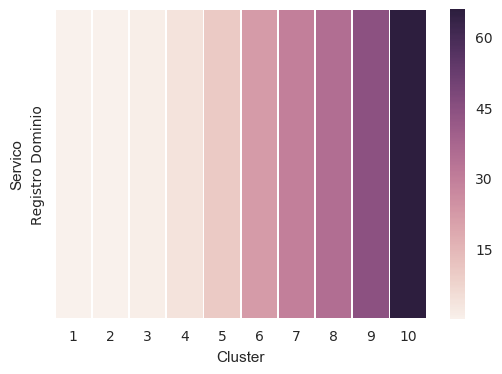

In [57]:
for i in heatmap.columns:
    heatmap[i] = heatmap[i]*100
sns.heatmap(heatmap.drop('total', axis = 1), annot=False, linewidths=.5)    

In [58]:
#NomeCSV = 'Prob_Churn_ResumoTreino.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [59]:
#RESUMO

# Aplicando na Base-  Registro de Dominio

In [60]:
fim_janela_feature = df_base.Instalacao.max()
inicio_janela_churn = fim_janela_feature

df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                    (df_base.MesesParaChurn == 0) &
                    (df_base.Status == 'ativo') &
                    (df_base.Servico == 'Registro Dominio')].copy()

In [61]:
agg_dict = {'Provisioning' : 'count'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'Provisioning': 'Qtd_Provisioning'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

agg_dict = {'nr_PrecoMensal' : 'sum'}
aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
aux.reset_index(inplace= True)
aux.rename(columns= {'nr_PrecoMensal': 'Valor_cliente_Mes'}, inplace= True)
df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')

In [62]:
df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
df_treino['quantidade_renovacoes'] = [int(id_prov/peri_mes) for 
                                      id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                       peri_mes,idade_prov,qtd_renov in 
                                       zip(df_treino.Periodicidade_Meses, 
                                           df_treino.idade_prov, 
                                           df_treino.quantidade_renovacoes)]
df_treino['mes_Proxima_renovacao'] = [datetime((d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).year,
                                               (d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).month,1) 
                                      for d, qtd_renovacoes, periodicidade, mdelta in 
                                      zip (df_treino.Instalacao_AnoMes, 
                                           df_treino.quantidade_renovacoes,
                                           df_treino.Periodicidade_Meses,
                                           df_treino.Qtd_meses_P_renovacoes)]

In [63]:
tamanho = len(lista_perfil) 
df_treino['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                               for variavel in df_treino.Perfil]
tamanho = len(lista_classificacao) 
df_treino['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                     for variavel in df_treino.classificacao]
tamanho = len(lista_servico) 
df_treino['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                               for variavel in df_treino.Servico]

In [64]:
df_treino.fillna(0, inplace= True)

In [65]:
X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)
y_pred = clf_RegDom.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)
y_pred.shape
df_treino = pd.concat([df_treino, y_pred], axis=1)

In [66]:
df_treino.sort_values(['Prob_Churn'], ascending= 1 ,inplace=True)

In [67]:
df_treino.reset_index(inplace= True, drop= True)
df_treino.reset_index(inplace= True)

In [68]:
df_treino.rename(columns= {'index': 'aux_cluster'}, inplace= True)

In [69]:
lista = [round(aux_Cluster[aux_Cluster.index == 1].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 2].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 3].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 4].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 5].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 6].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 7].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 8].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 9].Perc.max()*df_treino.aux_cluster.max(),0)]

In [70]:
lista[1] = lista[1] + lista[0]
lista[2] = lista[2] + lista[1]
lista[3] = lista[3] + lista[2]
lista[4] = lista[4] + lista[3]
lista[5] = lista[5] + lista[4]
lista[6] = lista[6] + lista[5]
lista[7] = lista[7] + lista[6]
lista[8] = lista[8] + lista[7]

In [71]:
#lista

In [72]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.aux_cluster]

In [73]:
#df_treino.Cluster.value_counts()

In [74]:
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'Valor_cliente_Mes' : 'mean',
                  'Periodicidade_Meses' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean'}
RESUMO = df_treino.groupby('Cluster').agg(dict_lista_aux)

#NomeCSV = 'Prob_Churn_ResumoBaseAtiva.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [75]:
#NomeCSV = 'Prob_Churn.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#df_treino[['Cluster','Provisioning']].set_index(['Cluster']).to_csv(NomeCSV)

In [76]:
#NomeCSV
#RESUMO

In [77]:
df_RegDominio = df_treino.copy()

In [78]:
df_RegDominio.shape

(211608, 40)

# Junta Bases

In [79]:
frames = [df_ExcetoRegDominio, df_RegDominio]
df_final = pd.concat(frames)

In [80]:
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Churn' : 'min',
                  'FlagChurn' : 'mean',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'Valor_cliente_Mes' : 'mean',
                  'Periodicidade_Meses' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean'}
RESUMO = df_final.groupby('Cluster').agg(dict_lista_aux)
#NomeCSV = 'Prob_Churn_ResumoBaseAtiva.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [81]:
#RESUMO

In [82]:
agg_dict_heatmap = {'Provisioning' : 'count'}
heatmap = df_final.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
heatmap.reset_index(inplace= True)
heatmap = heatmap.pivot('Cluster','Servico', 'Provisioning').copy()
heatmap.fillna(0, inplace= True)
heatmap = heatmap.T
heatmap['total'] = heatmap[heatmap.columns].sum(axis = 1)
heatmap.sort('total', ascending= 0, inplace= True)
heatmap

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10,total
Servico,,,,,,,,,,,
Registro Dominio,47611.0,34379.0,28045.0,24864.0,24335.0,29093.0,13770.0,5277.0,2113.0,2121.0,211608.0
Hospedagem,107835.0,29392.0,24961.0,15114.0,10929.0,8515.0,6005.0,2461.0,1151.0,991.0,207354.0
Email,16075.0,2468.0,1241.0,632.0,215.0,153.0,138.0,95.0,166.0,99.0,21282.0
Criador de Sites,14011.0,201.0,34.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,14258.0
Email MKT,622.0,1033.0,1928.0,1419.0,2095.0,1750.0,1302.0,731.0,637.0,451.0,11968.0
Exchange,5149.0,2955.0,1899.0,515.0,174.0,30.0,64.0,55.0,28.0,18.0,10887.0
Cloud Server Pro,1811.0,1199.0,2052.0,2688.0,1175.0,450.0,409.0,239.0,210.0,166.0,10399.0
Revenda Hosp.,1569.0,1457.0,2022.0,1558.0,920.0,241.0,188.0,198.0,221.0,127.0,8501.0
PABX Virtual,803.0,1125.0,1160.0,818.0,225.0,200.0,312.0,124.0,163.0,163.0,5093.0


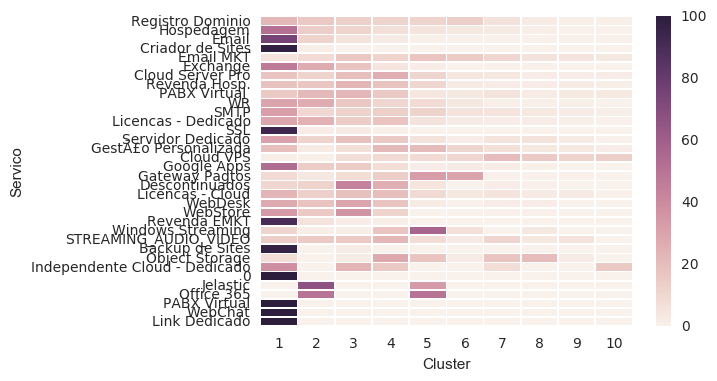

In [83]:
import seaborn as sns
for i in heatmap.columns:
    heatmap[i] = heatmap[i]*100/heatmap['total'] 
sns.heatmap(heatmap.drop('total', axis = 1), annot=False, linewidths=.5)    